In [1]:
# Visualization for reconstructed proteomic profiles using Spatial-DC and eight state-of-the-art deconvolution methods from Mouse PDAC data
# Yuan
# 20241127

In [1]:
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr,spearmanr
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib as mat
import os
import sys
from scipy import stats

import cell2location
import matplotlib.colors as mcolors

import warnings
from sklearn.preprocessing import MinMaxScaler,StandardScaler
warnings.filterwarnings("ignore")


plt.rcParams['font.size'] = 10
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

/data/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
Global seed set to 0
2024-11-27 17:30:58.603438: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Visualization of reconstructed proteomic profiles
- Fig. 6

         Falling back to preprocessing with `sc.pp.pca` and default params.


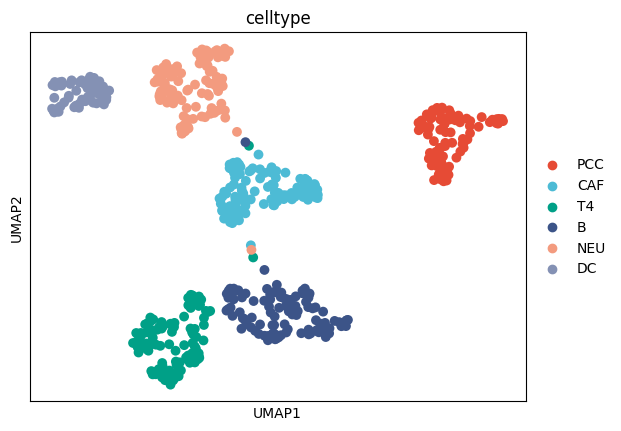

In [4]:
# impute with random distribution for 14 ct proteomics data
os.chdir("/aaa/zihanwu/yyyli2/project1_spatial_deconv/Manuscript_V20241119/MousePDAC2023/02_proteomic_profiles")

scp_adata = sc.read_h5ad("03_benchmark_methods/exp_ct10_impute_v2/SpatialDC/reconstruct_norm.h5ad")

sc.pp.filter_cells(scp_adata, min_counts=10)
sc.pp.filter_genes(scp_adata, min_cells=3)

scp_adata = scp_adata[scp_adata.obs["cellperc"] > 0.01]

sc.pp.normalize_total(scp_adata)
sc.pp.log1p(scp_adata)

ct_order = ["PCC", "CAF", "T4", "B","NEU", "DC"]

scp_adata.obs["celltype"] = scp_adata.obs["celltype"].astype("category")
scp_adata.obs["celltype"] = scp_adata.obs["celltype"].cat.set_categories(ct_order,ordered=False)

sc.pp.neighbors(scp_adata, n_pcs=20, n_neighbors=10)
sc.tl.umap(scp_adata)

my_palette = ["#E64B35FF", "#4DBBD5FF", "#00A087FF", "#3C5488FF", "#F39B7FFF", "#8491B4FF","#91D1C2FF", "#DC0000FF", "#7E6148FF", "#B09C85FF"]
scp_adata.uns["celltype_colors"] = my_palette


sc.pl.umap(scp_adata, color=["celltype"], size=200,save="_MousePDAC_Reconstruct_ct6_impute_umap.pdf")


In [ ]:
# DEP, for identify of known markers
# this replace R to calculate ANOVA sig. 
os.chdir("/aaa/zihanwu/yyyli2/project1_spatial_deconv/Manuscript_V20241119/MousePDAC2023/02_proteomic_profiles")
scp_adata = sc.read_h5ad("03_benchmark_methods/exp_ct10_impute_v2/SpatialDC/reconstruct_norm.h5ad")

sc.pp.filter_cells(scp_adata, min_counts=10)
sc.pp.filter_genes(scp_adata, min_cells=3)
scp_adata = scp_adata[scp_adata.obs["cellperc"] > 0.01]

scp_adata = scp_adata[scp_adata.obs["celltype"] != "Treg"]
scp_adata = scp_adata[scp_adata.obs["celltype"] != "MAC"]
scp_adata = scp_adata[scp_adata.obs["celltype"] != "T8"]
scp_adata = scp_adata[scp_adata.obs["celltype"] != "MO"]

df = scp_adata.var
df['pids'] = df.apply(lambda row: str(row['gene']) +"_"+ str(row['pid']), axis=1)
scp_adata.var.index = scp_adata.var["pids"]

sc.pp.normalize_total(scp_adata)
scp_adata.raw = scp_adata.copy()
sc.pp.log1p(scp_adata)
sc.tl.rank_genes_groups(scp_adata, 'celltype', method='t-test',use_raw=False)

result = scp_adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
marker_panel = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores']}).head(5)


ct_order = scp_adata.obs.celltype.cat.categories

scp_adata.obs["celltype"] = scp_adata.obs["celltype"].cat.set_categories(ct_order,ordered=False)

ct_order_n = [i+"_n" for i in ct_order]

markers = marker_panel[ct_order_n]
markers_list = []
for i in markers.columns:
    markers_list.extend(markers[i].to_list())

markers_list = [x for i, x in enumerate(markers_list) if x not in markers_list[:i]]  

ax=sc.pl.matrixplot(scp_adata, markers_list,'celltype',return_fig=True,dendrogram=False,swap_axes="False",figsize=[7,10],cmap="Blues",standard_scale="var")
ax.edge_color="none"
ax.show()
# ax.savefig("figures/markers_top2_pheatmap.pdf")
result = scp_adata.uns['rank_genes_groups']

result_dict = result
df_list = []
for celltype in result_dict["names"].dtype.names:
    df = pd.DataFrame(result_dict["scores"][celltype], columns=["score"])
    df["pvals_adj"] = result_dict["pvals_adj"][celltype]
    df["logfoldchanges"] = result_dict["logfoldchanges"][celltype]
    df["celltype"] = celltype
    df["feature"] = result_dict["names"][celltype]
    df_list.append(df)
merged_df = pd.concat(df_list)

merged_df.to_csv("analysis/ct10_impute_v2_dep_anno.csv")

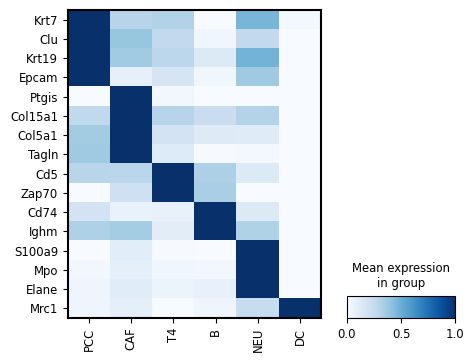

In [26]:
# vis of DEP
# Fig. 6b
os.chdir("/aaa/zihanwu/yyyli2/project1_spatial_deconv/Manuscript_V20241119/MousePDAC2023/02_proteomic_profiles")
scp_adata = sc.read_h5ad("03_benchmark_methods/exp_ct10_impute_v2/SpatialDC/reconstruct_norm.h5ad")

sc.pp.filter_cells(scp_adata, min_counts=10)
sc.pp.filter_genes(scp_adata, min_cells=3)
scp_adata = scp_adata[scp_adata.obs["cellperc"] > 0.01]

scp_adata = scp_adata[scp_adata.obs["celltype"] != "Treg"]
scp_adata = scp_adata[scp_adata.obs["celltype"] != "MAC"]
scp_adata = scp_adata[scp_adata.obs["celltype"] != "T8"]
scp_adata = scp_adata[scp_adata.obs["celltype"] != "MO"]

df = scp_adata.var
df['pids'] = df.apply(lambda row: str(row['gene']) +"_"+ str(row['pid']), axis=1)
scp_adata.var.index = scp_adata.var["pids"]

sc.pp.normalize_total(scp_adata)
# scp_adata.raw = scp_adata.copy()
# sc.pp.log1p(scp_adata)

ct_order = ["PCC", "CAF", "T4", "B","NEU", "DC"]

scp_adata.obs["celltype"] = scp_adata.obs["celltype"].astype("category")
scp_adata.obs["celltype"] = scp_adata.obs["celltype"].cat.set_categories(ct_order,ordered=False)


markers_list=["Krt7_Q9DCV7","Clu_Q06890","Krt19_P19001","Epcam_Q99JW5",#PCC
    "Ptgis_O35074","Col15a1_O35206","Col5a1_O88207","Tagln_P37804",#CAF
    "Cd5_P13379","Zap70_P43404",#T4
    "Cd74_P04441","Ighm_P01872",#B
    "S100a9_P31725","Mpo_P11247","Elane_Q3UP87",#NEU
    "Mrc1_Q61830"

]

scp_adata = scp_adata[:,markers_list].copy()
scp_adata.var.index = scp_adata.var["gene"]

markers_list=["Krt7","Clu","Krt19","Epcam",#PCC
    "Ptgis","Col15a1","Col5a1","Tagln",#CAF
    "Cd5","Zap70",#T4
    "Cd74","Ighm",#B
    "S100a9","Mpo","Elane",#NEU
    "Mrc1"

]

ax=sc.pl.matrixplot(scp_adata, markers_list,'celltype',return_fig=True,dendrogram=False,swap_axes="False",figsize=[5,4],cmap="Blues",standard_scale="var")
ax.edge_color="none"
ax.show()
# ax.savefig("figures/vis_known_markers.pdf")
# merged_df.to_csv("ct10_impute_v2_dep_anno.csv")

         Falling back to preprocessing with `sc.pp.pca` and default params.


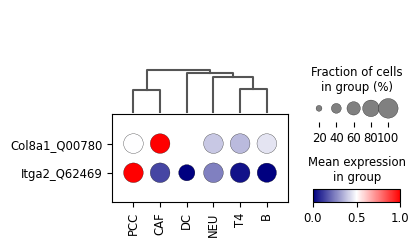

In [21]:
# vis of dot plot 
# Fig. 6i
colors = ['navy',"white", 'red']#['black','navy',"orange", 'red']
my_cmap = mcolors.LinearSegmentedColormap.from_list('mycmap', colors)

os.chdir("/aaa/zihanwu/yyyli2/project1_spatial_deconv/Manuscript_V20241119/MousePDAC2023/02_proteomic_profiles")
scp_adata = sc.read_h5ad("03_benchmark_methods/exp_ct10_impute_v2/SpatialDC/reconstruct_norm.h5ad")

sc.pp.filter_cells(scp_adata, min_counts=10)
sc.pp.filter_genes(scp_adata, min_cells=3)
scp_adata = scp_adata[scp_adata.obs["cellperc"] > 0.01]

scp_adata = scp_adata[scp_adata.obs["celltype"] != "Treg"]
scp_adata = scp_adata[scp_adata.obs["celltype"] != "MAC"]
scp_adata = scp_adata[scp_adata.obs["celltype"] != "T8"]
scp_adata = scp_adata[scp_adata.obs["celltype"] != "MO"]

df = scp_adata.var
df['pids'] = df.apply(lambda row: str(row['gene']) +"_"+ str(row['pid']), axis=1)
scp_adata.var.index = scp_adata.var["pids"]

sc.pp.normalize_total(scp_adata)
scp_adata.raw = scp_adata.copy()
sc.pp.log1p(scp_adata)

ct_order = ["PCC", "CAF", "T4", "B","NEU", "DC"]

scp_adata.obs["celltype"] = scp_adata.obs["celltype"].cat.set_categories(ct_order,ordered=False)

PPI_markers = ["Col8a1_Q00780","Itga2_Q62469"]

# sc.pl.stacked_violin(scp_adata, PPI_markers, groupby="celltype",figsize=[5,3],standard_scale="var",swap_axes="True",vmax=1,cmap=my_cmap)
sc.pl.dotplot(scp_adata, PPI_markers, groupby='celltype', dendrogram=True,standard_scale="var",swap_axes="True",cmap=my_cmap,save="PPI_selected_Col8a1_Itga2.pdf")

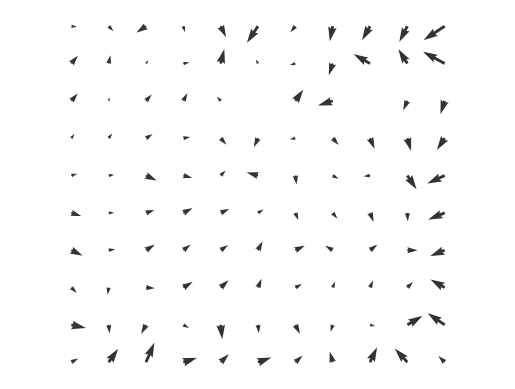

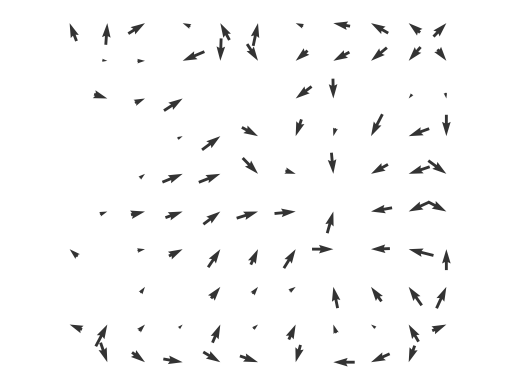

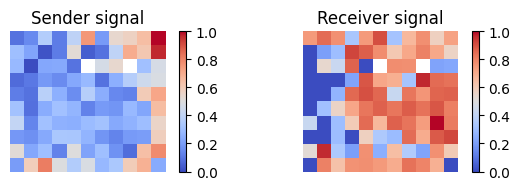

In [9]:
# CAF and PC communications analysis
import gc
import ot
import pickle
from scipy import sparse
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

import commot as ct

os.chdir("/aaa/zihanwu/yyyli2/project1_spatial_deconv/Manuscript_V20241119/MousePDAC2023/02_proteomic_profiles")
scp_adata = sc.read_h5ad("03_benchmark_methods/exp_ct10_impute_v2/SpatialDC/reconstruct_not_norm.h5ad")

# set zero of cellperc<0
set_zero = scp_adata.obs["cellperc"] < 0.01
temp_arr = np.array(scp_adata.to_df())
temp_arr[set_zero,:]=0
scp_adata.X = temp_arr

# keep target cells, first CAF and then PC
ct_order = ["CAF"]
keep_index = scp_adata.var["gene"].isin(["Col8a1","Itga2"])
keep_ct = scp_adata.obs["celltype"].isin(ct_order)
target_adata = scp_adata[keep_ct,keep_index].copy()


df = target_adata.var
df['pids'] = df.apply(lambda row: str(row['gene']) +"_"+ str(row['pid']), axis=1)
target_adata.var.index = target_adata.var["gene"]
temp_index = [f"spot_{i}" for i in range(target_adata.shape[0])]
target_adata.obs.index = temp_index

temp_df = target_adata.to_df()

ct_order = ["PCC"]
keep_index = scp_adata.var["gene"].isin(["Itga2"])
keep_ct = scp_adata.obs["celltype"].isin(ct_order)
temp_df["Itga2"]  = scp_adata[keep_ct,keep_index].to_df().values

target_adata.X = np.array(temp_df)

# prepare adata
target_adata.obs[["Y"]] = -target_adata.obs[["Y"]]
target_adata.obsm["spatial"] = np.array(target_adata.obs[["X","Y"]])
# sc.pp.normalize_total(target_adata)
# target_adata.raw = target_adata.copy()
sc.pp.log1p(target_adata)

scaler = MinMaxScaler(feature_range=(0, 1))
# inputs = scaler.fit_transform(target_adata.to_df())
# target_adata.X = inputs

# 准备PPI
target_ppi_df = pd.DataFrame({0:'Col8a1',1:'Itga2',2:'sig_ppi',3:'Secreted Signaling'},index=[0,1,2,3])
ct.tl.spatial_communication(target_adata,
    database_name='selected_db', df_ligrec=target_ppi_df, dis_thr=500, heteromeric=True, pathway_sum=True) 

# 展示信号传递的方向
ct.tl.communication_direction(target_adata, database_name='selected_db', pathway_name='sig_ppi', k=5)

ct.pl.plot_cell_communication(target_adata, database_name='selected_db', pathway_name='sig_ppi',normalize_v=True,normalize_v_quantile=0.995,summary="sender",
grid_density=0.4,scale=1.5,ndsize=0,grid_thresh=10,grid_scale=10,filename="sender.pdf",plot_method="cell")

ct.pl.plot_cell_communication(target_adata, database_name='selected_db', pathway_name='sig_ppi',normalize_v=True,normalize_v_quantile=0.995,clustering=None,summary="receiver",
grid_density=0.4,scale=1.5,ndsize=0,grid_thresh=10,grid_scale=10,filename="receiver.pdf",plot_method="cell")


# # 绘制每个蛋白的空间分布图
adata = target_adata.copy()
pts = adata.obsm['spatial']

adata.obsm['commot-selected_db-sum-sender'][['s-Col8a1-Itga2']]= scaler.fit_transform(adata.obsm['commot-selected_db-sum-sender'][['s-Col8a1-Itga2']])  
adata.obsm['commot-selected_db-sum-receiver'][['r-Col8a1-Itga2']]= scaler.fit_transform(adata.obsm['commot-selected_db-sum-receiver'][['r-Col8a1-Itga2']])  

s = adata.obsm['commot-selected_db-sum-sender']['s-Col8a1-Itga2']
r = adata.obsm['commot-selected_db-sum-receiver']['r-Col8a1-Itga2']


fig, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(6, 2))

sc1 = ax1[0].scatter(pts[:,0], pts[:,1],s=105, edgecolors='none', facecolors='none',marker="s",
        c=s,cmap='coolwarm')
ax1[0].set_aspect('equal', 'box')
ax1[0].set_xticks([])
ax1[0].set_yticks([])

ax1[0].set_title("Sender signal")
ax1[0].axis('off')

sc2 = ax1[1].scatter(pts[:,0], pts[:,1],s=105, edgecolors='none', facecolors='none',marker="s",
        c=r,cmap='coolwarm')
ax1[1].set_aspect('equal', 'box')
ax1[1].set_xticks([])
ax1[1].set_yticks([])

ax1[1].set_title("Receiver signal")
ax1[1].axis('off')

fig.colorbar(sc1, ax=ax1[0])
fig.colorbar(sc2, ax=ax1[1])
plt.tight_layout()
plt.show()
# plt.savefig("figures/Sender_Receiver_Col8a2_Itga2.pdf")

# # save table
# adata.obsm['commot-selected_db-sum-sender'].to_csv("figures/Sender_Col8a2_Itga2.csv")
# adata.obsm['commot-selected_db-sum-receiver'].to_csv("figures/Receiver_Col8a2_Itga2.csv")

In [ ]:
# Survial analysis, PPI and cell-cell interaction analysis
# with R script in *tools*
# Fig. 6e,f, and j